In [ ]:
!pip install -q datasets transformers accelerate evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import torch
from datasets import load_dataset, Sequence, Value
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
)
from sklearn.metrics import f1_score
import evaluate

# Cek device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
if device == "cuda":
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU Name: Tesla T4


In [ ]:
dataset = load_dataset("go_emotions")
print(dataset)
print(dataset["train"][0])
print("type(labels):", type(dataset["train"][0]["labels"]))
print("labels:", dataset["train"][0]["labels"])

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

simplified/train-00000-of-00001.parquet:   0%|          | 0.00/2.77M [00:00<?, ?B/s]

simplified/validation-00000-of-00001.par(…):   0%|          | 0.00/350k [00:00<?, ?B/s]

simplified/test-00000-of-00001.parquet:   0%|          | 0.00/347k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/43410 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5426 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5427 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 43410
    })
    validation: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5426
    })
    test: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5427
    })
})
{'text': "My favourite food is anything I didn't have to cook myself.", 'labels': [27], 'id': 'eebbqej'}
type(labels): <class 'list'>
labels: [27]


In [ ]:
label_names = dataset["train"].features["labels"].feature.names   # Ambil daftar nama label dari fitur 'labels' di dataset train
num_labels = len(label_names)                                     # Hitung berapa banyak label (ukuran vektor multi-label)
print("num_labels:", num_labels)                                  # Cetak jumlah label
print("contong label id:", dataset["train"][0]["labels"])         # Tampilkan ID label untuk sampel pertama (bisa list beberapa id)
print("nama label:", [label_names[i] for i in dataset["train"][0]["labels"]]) # Konversi ID label pada sampel pertama ke nama label yang terbaca manusia

def ids_to_multihot(batch):                                       # Fungsi untuk mengubah list id label menjadi vektor multi-hot
    new_labels = []                                               # List penampung vektor label baru (multi-hot)
    for lab_ids in batch["labels"]:                               # Loop tiap contoh dalam batch (tiap contoh punya list id label)
        v = [0.0] * num_labels                                    # Inisialisasi vektor nol dengan panjang = jumlah label
        for idx in lab_ids:                                       # Loop setiap id label pada contoh tersebut
            v[idx] = 1.0                                          # Set posisi index label jadi 1.0 (berarti label itu aktif)
        new_labels.append(v)                                      # Simpan vektor multi-hot ke list penampung
    batch["labels"] = new_labels                                  # Ganti isi kolom 'labels' di batch dengan vektor multi-hot
    return batch                                                  # Kembalikan batch yang sudah dimodifikasi

dataset = dataset.map(ids_to_multihot, batched=True)              # Terapkan konversi multi-hot ke seluruh dataset secara batch

num_labels: 28
contong label id: [27]
nama label: ['neutral']


Map:   0%|          | 0/43410 [00:00<?, ? examples/s]

Map:   0%|          | 0/5426 [00:00<?, ? examples/s]

Map:   0%|          | 0/5427 [00:00<?, ? examples/s]

In [ ]:
new_features = dataset["train"].features.copy()          # Salin definisi fitur (schema kolom) dari split train dataset
new_features["labels"] = Sequence(Value("float32"))      # Ubah tipe fitur 'labels' menjadi urutan (Sequence) berisi float32
dataset = dataset.cast(new_features)                     # Cast/konversi seluruh dataset agar mengikuti schema fitur baru


ex = dataset["train"][0]                                 # Ambil satu contoh (sample) dari split train untuk dicek
print(len(ex["labels"]), ex["labels"][:10], type(ex["labels"][0]))
# Cetak:
# - panjang vektor labels (harus = num_labels)
# - 10 elemen pertama dari vektor labels
# - tipe data elemen vektor labels (harus float, sesuai Value("float32"))

Casting the dataset:   0%|          | 0/43410 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/5426 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/5427 [00:00<?, ? examples/s]

28 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] <class 'float'>


In [ ]:
model_name = "distilbert-base-uncased"                       # Nama model pretrained yang akan dipakai (DistilBERT versi uncased)
tokenizer = AutoTokenizer.from_pretrained(model_name)        # Load tokenizer yang sesuai dengan model DistilBERT tersebut

def tokenize_batch(batch):                                   # Fungsi untuk men-tokenisasi satu batch contoh data
    out = tokenizer(
        batch["text"],                                       # Kolom teks dari dataset yang akan di-tokenisasi
        truncation=True,                                     # Potong teks jika melebihi max_length
        padding=False,                                       # Tidak padding di sini (padding bisa dilakukan kemudian di DataCollator)
        max_length=128,                                      # Panjang maksimum sequence token (128 token)
    )
    out["labels"] = batch["labels"]                          # Copy kolom 'labels' asli ke output supaya tidak hilang
    return out                                               # Kembalikan batch yang sudah berisi input_ids, attention_mask, dan labels

tokenized = dataset.map(tokenize_batch, batched=True)        # Terapkan fungsi tokenize_batch ke seluruh dataset secara batch

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/43410 [00:00<?, ? examples/s]

Map:   0%|          | 0/5426 [00:00<?, ? examples/s]

Map:   0%|          | 0/5427 [00:00<?, ? examples/s]

In [ ]:
keep_cols = ["input_ids", "attention_mask", "labels"]              # Daftar kolom yang ingin dipertahankan untuk training

tokenized = tokenized.remove_columns(                              # Hapus kolom-kolom lain yang tidak diperlukan
    [c for c in tokenized["train"].column_names if c not in keep_cols]
    # List comprehension: ambil semua nama kolom di split "train"
    # lalu pilih hanya yang TIDAK ada di keep_cols → kolom-kolom ini yang akan di-remove
)

print(tokenized)                                                   # Cetak ringkasan objek dataset yang sudah dibersihkan kolomnya
print(tokenized["train"][0])                                       # Cetak satu contoh pertama dari split train (input_ids, attention_mask, labels)

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 43410
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 5426
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 5427
    })
})
{'labels': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0], 'input_ids': [101, 2026, 8837, 2833, 2003, 2505, 1045, 2134, 1005, 1056, 2031, 2000, 5660, 2870, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
id2label = {i: l for i, l in enumerate(label_names)}        # Mapping dari index (id label, 0,1,2,...) ke nama label (string)
label2id = {l: i for i, l in enumerate(label_names)}        # Mapping kebalikannya: dari nama label ke id (integer)

model = AutoModelForSequenceClassification.from_pretrained( # Load model pretrained untuk tugas klasifikasi
    model_name,                                             # Nama model (distilbert-base-uncased)
    num_labels=num_labels,                                  # Jumlah neuron output = jumlah label (multi-label)
    id2label=id2label,                                      # Beri mapping id→label ke model (berguna saat output/prediksi)
    label2id=label2id,                                      # Beri mapping label→id ke model
    problem_type="multi_label_classification",              # Beritahu model bahwa ini tugas multi-label, bukan single-label
)

model.to(device)                                             # Pindahkan model ke device (GPU kalau ada, kalau tidak CPU)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [ ]:
def sigmoid(x):                                             # Definisi fungsi sigmoid manual
    return 1 / (1 + np.exp(-x))                             # Rumus sigmoid: memetakan nilai real → (0, 1)

def compute_metrics(eval_pred):                             # Fungsi untuk menghitung metrik evaluasi di multi-label
    logits, labels = eval_pred                              # logits: output mentah model, labels: label multi-hot (0/1 float)
    probs = sigmoid(logits)                                 # Ubah logits jadi probabilitas per label dengan sigmoid
    preds = (probs > 0.5).astype(int)                       # Konversi ke prediksi biner: > 0.5 jadi 1, lainnya 0

    # f1 untuk multi-label, boleh langsung pakai sklearn
    f1_micro = f1_score(                                    # Hitung F1-score dengan average "micro"
        y_true=labels,                                      #   - Menghitung global TP/FP/FN di semua label
        y_pred=preds,                                       #   - Cocok untuk lihat performa overall
        average="micro",
        zero_division=0,                                    # Jika tidak ada positive prediction, hindari error (hasil 0)
    )
    f1_macro = f1_score(                                    # Hitung F1-score dengan average "macro"
        y_true=labels,                                      #   - Hitung F1 per label, lalu rata-ratakan
        y_pred=preds,                                       #   - Memberi bobot sama ke tiap label (meskipun jarang)
        average="macro",
        zero_division=0,
    )
    exact_match = (preds == labels).all(axis=1).mean()      # Exact match ratio:
                                                            #   - True jika SELURUH label per sample tepat semua
                                                            #   - Lalu dirata-rata (persentase sample yang 100% benar)
    return {                                                # Kembalikan dictionary berisi semua metrik
        "f1_micro": f1_micro,                               # F1 micro (global)
        "f1_macro": f1_macro,                               # F1 macro (rata per label)
        "exact_match": exact_match,                         # Persentase prediksi yang persis sama dengan label multi-hot
    }

In [ ]:
batch_size = 16                                              # Ukuran batch untuk training dan evaluasi (16 contoh per batch)

training_args = TrainingArguments(                           # Objek pengaturan untuk proses training dengan Trainer
    output_dir="./goemotion-bert",                           # Folder untuk menyimpan checkpoint/model hasil training
    eval_strategy="epoch",                                   # (Seharusnya 'evaluation_strategy') evaluasi dilakukan setiap epoch
    save_strategy="epoch",                                   # Simpan checkpoint model di akhir setiap epoch
    load_best_model_at_end=True,                             # Setelah training selesai, muat model terbaik (berdasarkan metric)
    metric_for_best_model="f1_micro",                        # Metrik acuan untuk pilih model terbaik adalah F1 micro
    greater_is_better=True,                                  # Semakin besar nilai metrikkya, semakin baik (dipakai untuk pemilihan model)
    per_device_train_batch_size=batch_size,                  # Batch size per device (GPU/CPU) saat training
    per_device_eval_batch_size=batch_size,                   # Batch size per device (GPU/CPU) saat evaluasi
    num_train_epochs=3,                                      # Jumlah epoch (berapa kali seluruh data training dilalui)
    learning_rate=2e-5,                                      # Learning rate untuk optimizer (lebih kecil dari sebelumnya)
    weight_decay=0.01,                                       # Weight decay (regularisasi) untuk mencegah overfitting
    logging_steps=100,                                       # Tulis log setiap 100 training step
    fp16=torch.cuda.is_available(),                          # Aktifkan mixed precision (float16) jika ada GPU (lebih cepat & hemat memori)
)

In [ ]:
trainer = Trainer(                                           # Inisialisasi HuggingFace Trainer untuk training & evaluasi
    model=model,                                             # Model DistilBERT yang sudah diset untuk multi-label classification
    args=training_args,                                      # Objek TrainingArguments (lr, epoch, batch_size, logging, dsb.)
    train_dataset=tokenized["train"],                        # Dataset training yang sudah di-tokenisasi dan punya labels multi-hot
    eval_dataset=tokenized["validation"],                    # Dataset validation untuk mengevaluasi performa tiap epoch
    tokenizer=tokenizer,                                     # Tokenizer yang dipakai (untuk padding, truncation saat batching)
    data_collator=data_collator,                             # DataCollatorWithPadding (atau sejenis) untuk buat batch dengan padding dinamis
    compute_metrics=compute_metrics,                         # Fungsi custom untuk hitung metrik multi-label (F1 micro, F1 macro, exact match)
)

/tmp/ipython-input-845020483.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
train_result = trainer.train()
trainer.save_model()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 2


wandb: You chose 'Use an existing W&B account'
wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Find your API key here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: ERROR Invalid API key: API key may only contain the letters A-Z, digits and underscores.
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 2


wandb: You chose 'Use an existing W&B account'
wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Find your API key here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: rylsatriaa (rylsatriaa-telkom-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,F1 Micro,F1 Macro,Exact Match
1,0.089800,0.089631,0.533715,0.313750,0.409141
2,0.083100,0.084613,0.552899,0.382000,0.429783
3,0.075900,0.084355,0.569133,0.405345,0.451530


In [ ]:
def predict_emotions(text, threshold=0.3):                  # Fungsi untuk prediksi emosi (multi-label) dari teks
    model.eval()                                            # Set model ke mode evaluasi (non-training: matikan dropout, dsb.)
    device = next(model.parameters()).device                # Ambil device tempat model berada (GPU/CPU)

    if isinstance(text, str):                               # Jika input hanya satu string
        texts = [text]                                      # Jadikan list berisi 1 elemen supaya seragam
    else:                                                   # Jika sudah berupa list/iterable
        texts = text                                        # Pakai apa adanya

    with torch.no_grad():                                   # Blok tanpa gradien (hemat memori, lebih cepat untuk inference)
        inputs = tokenizer(                                 # Tokenisasi semua teks sekaligus
            texts,
            padding=True,                                   # Padding agar semua sequence punya panjang yang sama
            truncation=True,                                # Potong teks yang terlalu panjang
            return_tensors="pt"                             # Kembalikan hasil sebagai tensor PyTorch
        ).to(device)                                        # Pindahkan semua input ke device yang sama dengan model

        outputs = model(**inputs)                           # Jalankan forward pass model dengan input yang sudah di-tokenisasi
        logits = outputs.logits                             # Ambil logits (skor mentah) untuk tiap label emosi
        probs = torch.sigmoid(logits)                       # Ubah logits jadi probabilitas per label dengan sigmoid (0–1)

    results = []                                            # List untuk menyimpan hasil akhir tiap teks
    for i, p in enumerate(probs):                           # Loop tiap baris probabilitas (satu baris = satu teks)
        p = p.cpu()                                         # Pindahkan tensor probabilitas ke CPU
        indices = (p > threshold).nonzero(as_tuple=True)[0].tolist()
        # Ambil index label yang probabilitasnya > threshold (misal 0.3) → label dianggap aktif

        if len(indices) == 0:                               # Kalau tidak ada label yang melewati threshold
            indices = [int(torch.argmax(p))]                # Paksa pilih satu label dengan probabilitas tertinggi

        preds = []                                          # List prediksi (label, skor) untuk teks ini
        for idx in indices:                                 # Loop setiap index label terpilih
            label_name = id2label[idx]                      # Ambil nama label dari id2label
            score = float(p[idx])                           # Ambil skor probabilitasnya (konversi ke float biasa)
            preds.append((label_name, score))               # Tambahkan tuple (nama_label, skor) ke list preds

        results.append({"text": texts[i], "predictions": preds})
        # Simpan hasil untuk teks ke-i: teks asli dan daftar prediksi (label + skor)

    return results                                          # Kembalikan list hasil untuk semua teks input

In [ ]:
test_texts = [                                              # Daftar contoh kalimat untuk diuji emosi-nya
    "I am very happy today!",                               # Contoh kalimat dengan emosi positif (senang)
    "I feel really sad and disappointed.",                  # Contoh kalimat dengan emosi sedih/kecewa
    "I'm anxious about my exam tomorrow.",                  # Contoh kalimat dengan emosi cemas
    "That was so rude and unfair."                          # Contoh kalimat dengan emosi marah/tidak suka
]

results = predict_emotions(test_texts, threshold=0.3)       # Panggil fungsi prediksi emosi untuk semua kalimat di atas
                                                            # Threshold 0.3: label dengan prob > 0.3 dianggap aktif

for r in results:                                           # Loop setiap hasil prediksi untuk masing-masing teks
    print(f"Text : {r['text']}")                            # Cetak teks asli
    print("Predicted emotions:")                            # Judul untuk daftar emosi yang diprediksi
    for lbl, score in r["predictions"]:                     # Loop setiap (label, skor) yang diprediksi untuk teks itu
        print(f"  - {lbl}: {score:.3f}")                    # Cetak nama emosi dan skor probabilitasnya (3 digit desimal)
    print("-" * 40)                                         # Cetak garis pemisah antar contoh supaya output rapi

Text : I am very happy today!
Predicted emotions:
  - joy: 0.852
----------------------------------------
Text : I feel really sad and disappointed.
Predicted emotions:
  - sadness: 0.858
----------------------------------------
Text : I'm anxious about my exam tomorrow.
Predicted emotions:
  - nervousness: 0.241
----------------------------------------
Text : That was so rude and unfair.
Predicted emotions:
  - anger: 0.390
  - annoyance: 0.386
----------------------------------------


In [ ]:
import pandas as pd                                          # Import pandas untuk manipulasi & analisis data tabular

logs = trainer.state.log_history                            # Ambil riwayat log dari Trainer (list of dict berisi step, loss, eval_loss, dsb.)
df_logs = pd.DataFrame(logs)                                # Konversi list of dict menjadi DataFrame pandas

df_train = df_logs[df_logs['loss'].notna()].reset_index(drop=True)
# Filter hanya baris yang punya kolom 'loss' (bukan NaN) → log training
# reset_index(drop=True) → reset index dari 0 supaya rapi

df_eval = df_logs[df_logs['eval_loss'].notna()].reset_index(drop=True)
# Filter hanya baris yang punya kolom 'eval_loss' (bukan NaN) → log evaluasi
# reset_index(drop=True) → reset index dari 0

if 'step' not in df_train:                                  # Jika kolom 'step' tidak ada di df_train
    df_train['step'] = range(1, len(df_train) + 1)          # Buat kolom 'step' berisi nomor 1 sampai jumlah baris
if 'step' not in df_eval:                                   # Jika kolom 'step' tidak ada di df_eval
    df_eval['step'] = range(1, len(df_eval) + 1)            # Buat kolom 'step' berisi nomor 1 sampai jumlah baris

df_train.head(), df_eval.head()                             # Tampilkan 5 baris pertama dari df_train dan df_eval untuk inspeksi

(     loss  grad_norm  learning_rate     epoch  step  eval_loss  eval_f1_micro  \
 0  0.3858   0.556542       0.000020  0.036846   100        NaN            NaN   
 1  0.1772   0.297452       0.000020  0.073692   200        NaN            NaN   
 2  0.1550   0.282565       0.000019  0.110538   300        NaN            NaN   
 3  0.1510   0.311498       0.000019  0.147384   400        NaN            NaN   
 4  0.1425   0.346354       0.000019  0.184230   500        NaN            NaN   
 
    eval_f1_macro  eval_exact_match  eval_runtime  eval_samples_per_second  \
 0            NaN               NaN           NaN                      NaN   
 1            NaN               NaN           NaN                      NaN   
 2            NaN               NaN           NaN                      NaN   
 3            NaN               NaN           NaN                      NaN   
 4            NaN               NaN           NaN                      NaN   
 
    eval_steps_per_second  train_run

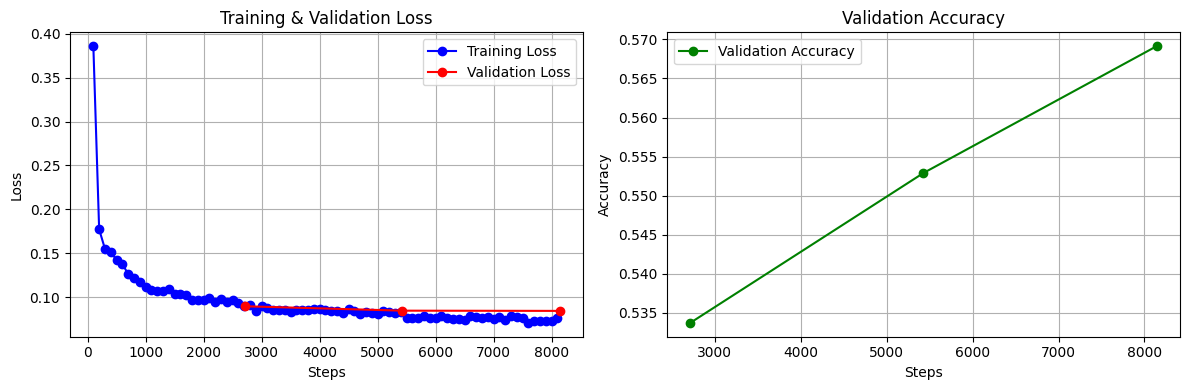

In [ ]:
import matplotlib.pyplot as plt                              # Import matplotlib untuk membuat visualisasi/plot

plt.figure(figsize=(12,4))                                  # Buat figure baru dengan ukuran 12x4 inch

# ---------- kiri: Training & Validation Loss ----------
plt.subplot(1,2,1)                                          # Subplot pertama (kiri) dari 1 baris 2 kolom
plt.plot(df_train['step'], df_train['loss'],                # Plot garis training loss
         marker='o', color='blue', label='Training Loss')   # Dengan marker bulat, warna biru, label "Training Loss"
plt.plot(df_eval['step'], df_eval['eval_loss'],             # Plot garis validation loss
         marker='o', color='red', label='Validation Loss')  # Dengan marker bulat, warna merah, label "Validation Loss"
plt.xlabel('Steps')                                         # Label sumbu-x
plt.ylabel('Loss')                                          # Label sumbu-y
plt.title('Training & Validation Loss')                     # Judul plot
plt.legend()                                                # Tampilkan legenda
plt.grid(True)                                              # Tampilkan grid untuk mempermudah pembacaan

# ---------- kanan: Validation "Accuracy" (pakai F1 micro) ----------
metric_name = 'eval_f1_micro'                               # Nama kolom metrik di dataframe (ganti jika namanya beda di log)
plt.subplot(1,2,2)                                          # Subplot kedua (kanan) dari 1 baris 2 kolom
plt.plot(df_eval['step'], df_eval[metric_name],             # Plot garis F1 micro (metrik validasi)
         marker='o', color='green', label='Validation Accuracy')  # Dengan marker bulat, warna hijau, label "Validation Accuracy"
plt.xlabel('Steps')                                         # Label sumbu-x
plt.ylabel('Accuracy')                                      # Label sumbu-y
plt.title('Validation Accuracy')                            # Judul plot
plt.legend()                                                # Tampilkan legenda
plt.grid(True)                                              # Tampilkan grid

plt.tight_layout()                                          # Atur layout agar subplot tidak saling tumpang tindih
plt.show()                                                  # Tampilkan semua grafik di figure